# Random Forest Classifier Model 1
## Initial model without modification on the missing input data
Dropping all NaNs values in 'Critic_Score' column

### Objective
Predict the class of total sales (low, medium, high) based on different features

### Input data
Since there are major missing values in 'Critic_Score' column (4706 non-null out of 19862 rows), this script will try 3 different input datasets, with and without 'Crtitic_Score' column, to see how it effects the model accuracy and feature importances. The 'Country' column is also dropped in the final dataset to increase number of input rows.
1. Dataframe 1: With 'Critic_Score' column
2. Dataframe 2: No 'Critic_Score' column
3. Dataframe 3: No 'Critic_Score' and 'Country' columns

### Create Additional 'Total_Sales_Class' column
The Total_Sales is categorized into 3 classes: low, medium, high. 
<br>Based on the number of total sales where the average is around 0.5 milliions, the binning is as follow:
- Low: total sales < 1 millions
- Medium: total sales higher than 1 millions and less than 10 millions
- High: total sales > 10 millions

### Target Variable and Features
- Target variable (y) = Total_Sales_Class (low, medium, high)
- X = Critic_Score, Genre, ESRB_Rating, Platform, Publisher, Developer_x, Country

### Machine Learning Models
- rf_model = RandomForestClassifier
- brf_model = BalancedRandomForestClassifier
- eec_model = EasyEnsembleClassifier


In [93]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from collections import Counter

from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import confusion_matrix
from imblearn.metrics import classification_report_imbalanced

In [94]:
# Load the dataset from AWS S3 bucket
#games_df = pd.read_csv('https://video-game-dataset-uot-boot-camp-2022-group-4.s3.us-east-2.amazonaws.com/all_columns_df.csv')
games_df = pd.read_csv('Cleaned_Data/all_columns_df.csv')
games_df

,Rank,Name,Genre,ESRB_Rating,Platform,Publisher,Developer_x,Critic_Score,User_Score,Year,Country,Total_Sales
0,1,Wii Sports,Sports,E,Wii,Nintendo,Nintendo EAD,7.7,NaN,2006.0,Japan,82.86
1,2,Super Mario Bros.,Platform,NaN,NES,Nintendo,Nintendo EAD,10.0,NaN,1985.0,Japan,40.24
2,3,Mario Kart Wii,Racing,E,Wii,Nintendo,Nintendo EAD,8.2,9.1,2008.0,Japan,37.14
3,4,PlayerUnknown's Battlegrounds,Shooter,NaN,PC,PUBG Corporation,PUBG Corporation,NaN,NaN,2017.0,NaN,36.60
4,5,Wii Sports Resort,Sports,E,Wii,Nintendo,Nintendo EAD,8.0,8.8,2009.0,Japan,33.09
...,...,...,...,...,...,...,...,...,...,...,...,...
19857,19858,FirePower for Microsoft Combat Flight Simulator 3,Simulation,T,PC,GMX Media,Shockwave Productions,NaN,NaN,2004.0,NaN,0.01
19858,19859,Tom Clancy's Splinter Cell,Shooter,T,PC,Ubisoft,Ubisoft,NaN,NaN,2003.0,Europe,0.01
19859,19860,Ashita no Joe 2: The Anime Super Remix,Fighting,NaN,PS2,Capcom,Capcom,NaN,NaN,2002.0,Japan,0.01
19860,19861,Tokyo Yamanote Boys for V: Main Disc,Adventure,NaN,PSV,Rejet,Rejet,NaN,NaN,2017.0,NaN,0.01


In [95]:
games_df.dtypes

Rank              int64
Name             object
Genre            object
ESRB_Rating      object
Platform         object
Publisher        object
Developer_x      object
Critic_Score    float64
User_Score      float64
Year            float64
Country          object
Total_Sales     float64
dtype: object

In [96]:
# Change 'Year' dtype to object
games_df['Year'] = pd.to_datetime(games_df['Year'], format = '%Y').dt.strftime('%Y')
games_df.dtypes

Rank              int64
Name             object
Genre            object
ESRB_Rating      object
Platform         object
Publisher        object
Developer_x      object
Critic_Score    float64
User_Score      float64
Year             object
Country          object
Total_Sales     float64
dtype: object

In [97]:
# Drop columns that won't be included in the analysis
games_df.drop(['Rank'], axis = 1, inplace = True)
games_df

,Name,Genre,ESRB_Rating,Platform,Publisher,Developer_x,Critic_Score,User_Score,Year,Country,Total_Sales
0,Wii Sports,Sports,E,Wii,Nintendo,Nintendo EAD,7.7,NaN,2006,Japan,82.86
1,Super Mario Bros.,Platform,NaN,NES,Nintendo,Nintendo EAD,10.0,NaN,1985,Japan,40.24
2,Mario Kart Wii,Racing,E,Wii,Nintendo,Nintendo EAD,8.2,9.1,2008,Japan,37.14
3,PlayerUnknown's Battlegrounds,Shooter,NaN,PC,PUBG Corporation,PUBG Corporation,NaN,NaN,2017,NaN,36.60
4,Wii Sports Resort,Sports,E,Wii,Nintendo,Nintendo EAD,8.0,8.8,2009,Japan,33.09
...,...,...,...,...,...,...,...,...,...,...,...
19857,FirePower for Microsoft Combat Flight Simulator 3,Simulation,T,PC,GMX Media,Shockwave Productions,NaN,NaN,2004,NaN,0.01
19858,Tom Clancy's Splinter Cell,Shooter,T,PC,Ubisoft,Ubisoft,NaN,NaN,2003,Europe,0.01
19859,Ashita no Joe 2: The Anime Super Remix,Fighting,NaN,PS2,Capcom,Capcom,NaN,NaN,2002,Japan,0.01
19860,Tokyo Yamanote Boys for V: Main Disc,Adventure,NaN,PSV,Rejet,Rejet,NaN,NaN,2017,NaN,0.01


In [98]:
# Sattistics of the Total_Sales column
games_df.describe()

,Critic_Score,User_Score,Total_Sales
count,4706.000000,238.000000,19862.000000
mean,7.269911,8.465546,0.530876
std,1.420956,1.215681,1.572634
min,1.000000,2.000000,0.010000
25%,6.500000,8.000000,0.050000
50%,7.500000,8.800000,0.160000
75%,8.300000,9.300000,0.450000
max,10.000000,10.000000,82.860000


## Bin Total_Sales and Create 'Total_Sales_Class' column

In [99]:
# Create bin for 'Total_Sales' column
bins = [0,1,10,100]
labels = ['low', 'medium', 'high']

In [100]:
# Bin 'Total_Sales' into new column
games_df['Total_Sales_Class'] = pd.cut(games_df['Total_Sales'], bins=bins, labels=labels, right=False)
games_df.head(30)

,Name,Genre,ESRB_Rating,Platform,Publisher,Developer_x,Critic_Score,User_Score,Year,Country,Total_Sales,Total_Sales_Class
0,Wii Sports,Sports,E,Wii,Nintendo,Nintendo EAD,7.7,NaN,2006,Japan,82.86,high
1,Super Mario Bros.,Platform,NaN,NES,Nintendo,Nintendo EAD,10.0,NaN,1985,Japan,40.24,high
2,Mario Kart Wii,Racing,E,Wii,Nintendo,Nintendo EAD,8.2,9.1,2008,Japan,37.14,high
3,PlayerUnknown's Battlegrounds,Shooter,NaN,PC,PUBG Corporation,PUBG Corporation,NaN,NaN,2017,NaN,36.60,high
4,Wii Sports Resort,Sports,E,Wii,Nintendo,Nintendo EAD,8.0,8.8,2009,Japan,33.09,high
5,Pokemon Red / Green / Blue Version,Role-Playing,E,GB,Nintendo,Game Freak,9.4,NaN,1998,Japan,31.38,high
6,New Super Mario Bros.,Platform,E,DS,Nintendo,Nintendo EAD,9.1,8.1,2006,Japan,30.80,high
7,Tetris,Puzzle,E,GB,Nintendo,Bullet Proof Software,NaN,NaN,1989,Japan,30.26,high
8,New Super Mario Bros. Wii,Platform,E,Wii,Nintendo,Nintendo EAD,8.6,9.2,2009,Japan,30.22,high
9,Minecraft,Misc,NaN,PC,Mojang,Mojang AB,10.0,NaN,2010,NaN,30.01,high


In [101]:
games_df.Total_Sales_Class.value_counts()

low       17420
medium     2355
high         87
Name: Total_Sales_Class, dtype: int64

In [102]:
# Dropping unnecessary columns
games_df.drop(['Name','User_Score', 'Year'], axis=1, inplace=True)
games_df

,Genre,ESRB_Rating,Platform,Publisher,Developer_x,Critic_Score,Country,Total_Sales,Total_Sales_Class
0,Sports,E,Wii,Nintendo,Nintendo EAD,7.7,Japan,82.86,high
1,Platform,NaN,NES,Nintendo,Nintendo EAD,10.0,Japan,40.24,high
2,Racing,E,Wii,Nintendo,Nintendo EAD,8.2,Japan,37.14,high
3,Shooter,NaN,PC,PUBG Corporation,PUBG Corporation,NaN,NaN,36.60,high
4,Sports,E,Wii,Nintendo,Nintendo EAD,8.0,Japan,33.09,high
...,...,...,...,...,...,...,...,...,...
19857,Simulation,T,PC,GMX Media,Shockwave Productions,NaN,NaN,0.01,low
19858,Shooter,T,PC,Ubisoft,Ubisoft,NaN,Europe,0.01,low
19859,Fighting,NaN,PS2,Capcom,Capcom,NaN,Japan,0.01,low
19860,Adventure,NaN,PSV,Rejet,Rejet,NaN,NaN,0.01,low


In [103]:
games_df.count()

Genre                19862
ESRB_Rating          13925
Platform             19862
Publisher            19862
Developer_x          19860
Critic_Score          4706
Country              11877
Total_Sales          19862
Total_Sales_Class    19862
dtype: int64

## Checking NaNs

In [104]:
# Check null values
games_df.count()

Genre                19862
ESRB_Rating          13925
Platform             19862
Publisher            19862
Developer_x          19860
Critic_Score          4706
Country              11877
Total_Sales          19862
Total_Sales_Class    19862
dtype: int64

In [105]:
# To see the row count if drop NaN in all columns
games_df.dropna().count()

Genre                3579
ESRB_Rating          3579
Platform             3579
Publisher            3579
Developer_x          3579
Critic_Score         3579
Country              3579
Total_Sales          3579
Total_Sales_Class    3579
dtype: int64

# Dataframe 1: with 'Critic_Score' column
row count after dropping NaNs = 3579

In [106]:
# Drop all NaNs values
no_nan_df = games_df.drop(['Total_Sales'], axis=1).dropna()
print(no_nan_df.shape)
no_nan_df.head()

(3579, 8)


,Genre,ESRB_Rating,Platform,Publisher,Developer_x,Critic_Score,Country,Total_Sales_Class
0,Sports,E,Wii,Nintendo,Nintendo EAD,7.7,Japan,high
2,Racing,E,Wii,Nintendo,Nintendo EAD,8.2,Japan,high
4,Sports,E,Wii,Nintendo,Nintendo EAD,8.0,Japan,high
5,Role-Playing,E,GB,Nintendo,Game Freak,9.4,Japan,high
6,Platform,E,DS,Nintendo,Nintendo EAD,9.1,Japan,high


## Bucket data to top 10 and other bins

In [107]:
# Check unique values
no_nan_df.nunique()

Genre                 18
ESRB_Rating            5
Platform              24
Publisher             62
Developer_x          774
Critic_Score          81
Country               11
Total_Sales_Class      3
dtype: int64

In [108]:
# Keep top 14 of Genre
top = no_nan_df.Genre.value_counts().index[0:14]
no_nan_df.Genre = np.where(no_nan_df.Genre.isin(top), no_nan_df.Genre,'other')

In [109]:
# Keep top 18 of Platform
top = no_nan_df.Platform.value_counts().index[0:18]
no_nan_df.Platform = np.where(no_nan_df.Platform.isin(top), no_nan_df.Platform,'other')

In [110]:
# Keep top 15 of Publisher
top = no_nan_df.Publisher.value_counts().index[0:15]
no_nan_df.Publisher = np.where(no_nan_df.Publisher.isin(top), no_nan_df.Publisher, 'other')

In [111]:
# Keep top 15 of Developer_x
top = no_nan_df.Developer_x.value_counts().index[0:15]
no_nan_df.Developer_x = np.where(no_nan_df.Developer_x.isin(top), no_nan_df.Developer_x,'other')

In [112]:
no_nan_df

,Genre,ESRB_Rating,Platform,Publisher,Developer_x,Critic_Score,Country,Total_Sales_Class
0,Sports,E,Wii,Nintendo,Nintendo EAD,7.7,Japan,high
2,Racing,E,Wii,Nintendo,Nintendo EAD,8.2,Japan,high
4,Sports,E,Wii,Nintendo,Nintendo EAD,8.0,Japan,high
5,Role-Playing,E,other,Nintendo,other,9.4,Japan,high
6,Platform,E,DS,Nintendo,Nintendo EAD,9.1,Japan,high
...,...,...,...,...,...,...,...,...
19732,Sports,E,GBA,2K Sports,other,6.6,United States,low
19767,Action,M,PC,Ubisoft,Capcom,7.1,Europe,low
19792,Shooter,T,PC,Activision,other,7.0,United States,low
19794,Action,E,GBA,Atlus,other,6.0,Japan,low


In [113]:
# Check unique values
no_nan_df.nunique()

Genre                15
ESRB_Rating           5
Platform             19
Publisher            16
Developer_x          16
Critic_Score         81
Country              11
Total_Sales_Class     3
dtype: int64

## Encoding categorical variables

In [114]:
# Assign features
X = no_nan_df.drop('Total_Sales_Class', axis = 1)
X

,Genre,ESRB_Rating,Platform,Publisher,Developer_x,Critic_Score,Country
0,Sports,E,Wii,Nintendo,Nintendo EAD,7.7,Japan
2,Racing,E,Wii,Nintendo,Nintendo EAD,8.2,Japan
4,Sports,E,Wii,Nintendo,Nintendo EAD,8.0,Japan
5,Role-Playing,E,other,Nintendo,other,9.4,Japan
6,Platform,E,DS,Nintendo,Nintendo EAD,9.1,Japan
...,...,...,...,...,...,...,...
19732,Sports,E,GBA,2K Sports,other,6.6,United States
19767,Action,M,PC,Ubisoft,Capcom,7.1,Europe
19792,Shooter,T,PC,Activision,other,7.0,United States
19794,Action,E,GBA,Atlus,other,6.0,Japan


In [115]:
X.dtypes

Genre            object
ESRB_Rating      object
Platform         object
Publisher        object
Developer_x      object
Critic_Score    float64
Country          object
dtype: object

In [116]:
# Encoding object dtype columns
X_cat = X.select_dtypes(include='object')
X_cat = list(X_cat.columns)
X_cat

['Genre', 'ESRB_Rating', 'Platform', 'Publisher', 'Developer_x', 'Country']

In [117]:
from sklearn.preprocessing import OneHotEncoder

# creating instance of one-hot-encoder
enc = OneHotEncoder(sparse=False)
# Fit and transform the OneHotEncoder using the categorical variable list
encode_df = pd.DataFrame(enc.fit_transform(X[X_cat]))

# Add the encoded variable names to the dataframe
encode_df.columns = enc.get_feature_names(X_cat)

encode_df

/opt/anaconda3/envs/mlenv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,Genre_Action,Genre_Action-Adventure,Genre_Adventure,Genre_Fighting,Genre_Misc,Genre_Music,Genre_Platform,Genre_Puzzle,Genre_Racing,Genre_Role-Playing,...,Country_Europe,Country_Finland,Country_France,Country_Japan,Country_Norway,Country_Poland,Country_Russia,Country_South Korea,Country_United Kingdom,Country_United States
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3574,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3575,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3576,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3577,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [118]:
# Reset X dataframe index to merge with encode_df
X.reset_index(drop=True, inplace=True)
X

,Genre,ESRB_Rating,Platform,Publisher,Developer_x,Critic_Score,Country
0,Sports,E,Wii,Nintendo,Nintendo EAD,7.7,Japan
1,Racing,E,Wii,Nintendo,Nintendo EAD,8.2,Japan
2,Sports,E,Wii,Nintendo,Nintendo EAD,8.0,Japan
3,Role-Playing,E,other,Nintendo,other,9.4,Japan
4,Platform,E,DS,Nintendo,Nintendo EAD,9.1,Japan
...,...,...,...,...,...,...,...
3574,Sports,E,GBA,2K Sports,other,6.6,United States
3575,Action,M,PC,Ubisoft,Capcom,7.1,Europe
3576,Shooter,T,PC,Activision,other,7.0,United States
3577,Action,E,GBA,Atlus,other,6.0,Japan


In [119]:
# Merge one-hot encoded features and drop the originals
X = X.merge(encode_df, left_index=True, right_index=True)
X = X.drop(X_cat,1)
X

/var/folders/gd/1878fbxd5zs899fs6znx1h_40000gn/T/ipykernel_12635/2670095812.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  X = X.drop(X_cat,1)


,Critic_Score,Genre_Action,Genre_Action-Adventure,Genre_Adventure,Genre_Fighting,Genre_Misc,Genre_Music,Genre_Platform,Genre_Puzzle,Genre_Racing,...,Country_Europe,Country_Finland,Country_France,Country_Japan,Country_Norway,Country_Poland,Country_Russia,Country_South Korea,Country_United Kingdom,Country_United States
0,7.7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,8.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,9.4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,9.1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3574,6.6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3575,7.1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3576,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3577,6.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [120]:
# Assign the target
y = no_nan_df['Total_Sales_Class']
y.value_counts()

low       2471
medium    1044
high        64
Name: Total_Sales_Class, dtype: int64

In [121]:
X.shape

(3579, 83)

In [122]:
y.shape

(3579,)

## Spliting and scale the data

In [123]:
# Split data to training and testing set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

# Check the balance of the target variables.
print(f"y_train: {Counter(y_train)}")
print(f"y_test: {Counter(y_test)}")

y_train: Counter({'low': 1876, 'medium': 759, 'high': 49})
y_test: Counter({'low': 595, 'medium': 285, 'high': 15})


In [124]:
# Creating a StandardScaler instance.
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
# Fitting the Standard Scaler with the training data.
X_scaler = scaler.fit(X_train)

# Scaling the data.
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

## Random Forest Classifier Model

In [125]:
# Create a random forest classifier.
from sklearn.ensemble import RandomForestClassifier
rf_model = RandomForestClassifier(n_estimators=128, random_state=78) 

In [126]:
# Fitting the model
rf_model_1 = rf_model.fit(X_train_scaled, y_train)
# Making predictions using the testing data.
y_pred_rf = rf_model_1.predict(X_test_scaled)

In [127]:
# Calculating the accuracy score.
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
acc_score = accuracy_score(y_test, y_pred_rf)

In [128]:
cm = confusion_matrix(y_test, y_pred_rf)

# Create a DataFrame from the confusion matrix.
cm_df = pd.DataFrame(
    cm, index=["Actual high", "Actual low", "Actual medium"], columns=["Predicted high", "Predicted low", "Predicted medium"])

In [129]:
# Displaying results
print('Model: Random Forest Classifier 1')
print("---------------------")
print("Confusion Matrix")
display(cm_df)
print("---------------------")
print(f"Accuracy Score : {acc_score}")
print("---------------------")
print("Classification Report")
print(classification_report(y_test, y_pred_rf))

Model: Random Forest Classifier 1
---------------------
Confusion Matrix


,Predicted high,Predicted low,Predicted medium
Actual high,7,0,8
Actual low,0,536,59
Actual medium,9,131,145


---------------------
Accuracy Score : 0.7687150837988826
---------------------
Classification Report
              precision    recall  f1-score   support

        high       0.44      0.47      0.45        15
         low       0.80      0.90      0.85       595
      medium       0.68      0.51      0.58       285

    accuracy                           0.77       895
   macro avg       0.64      0.63      0.63       895
weighted avg       0.76      0.77      0.76       895



## Rank the importance of features

In [130]:
# Calculate feature importance in the Random Forest model.
print("Feature Importance: rf model 1: all columns")
sorted(zip(rf_model_1.feature_importances_, X.columns), reverse=True)

Feature Importance: rf model 1: all columns


[(0.3176492905515143, 'Critic_Score'),
 (0.029025621895053633, 'Publisher_Nintendo'),
 (0.019921717180612877, 'ESRB_Rating_E'),
 (0.01923298079172473, 'Genre_Action'),
 (0.018998797435207014, 'ESRB_Rating_T'),
 (0.018916213428204487, 'Publisher_other'),
 (0.018867270489432375, 'Platform_PS3'),
 (0.018640913137604645, 'Genre_Role-Playing'),
 (0.016924481624913, 'Genre_Shooter'),
 (0.016833474699373775, 'Developer_x_other'),
 (0.01678570968334395, 'Platform_X360'),
 (0.01638498940339898, 'ESRB_Rating_E10'),
 (0.01623306685712942, 'Platform_PS2'),
 (0.015789252457687645, 'Platform_Wii'),
 (0.01563618611986504, 'Genre_Sports'),
 (0.015182925760740816, 'Platform_GC'),
 (0.014820357719501086, 'Platform_PS4'),
 (0.01432804377576969, 'Platform_PC'),
 (0.014288136476836471, 'ESRB_Rating_M'),
 (0.014228150699611912, 'Genre_Racing'),
 (0.013356144343861074, 'Genre_Platform'),
 (0.013320735277632691, 'Publisher_Electronic Arts'),
 (0.013092309221503706, 'Genre_Misc'),
 (0.012855305502731883, 'Plat

(0.0, 0.4)

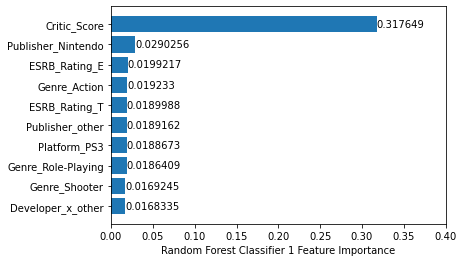

In [131]:
sorted_idx = rf_model_1.feature_importances_.argsort()[-10:]
x = X.columns[sorted_idx]
y = rf_model_1.feature_importances_[sorted_idx]

fig, ax = plt.subplots()
bars = ax.barh(x, y)
ax.bar_label(bars)
plt.xlabel("Random Forest Classifier 1 Feature Importance")
plt.xlim(0.0,0.4)

## Balanced Random Forest Classifier Model

In [132]:
# Resample the training data with the BalancedRandomForestClassifier
from imblearn.ensemble import BalancedRandomForestClassifier

brf_model = BalancedRandomForestClassifier(n_estimators=128, random_state = 78) 

# Fitting the model
brf_model_1 = brf_model.fit(X_train, y_train)

In [133]:
# Calculated the balanced accuracy score
y_pred_brf = brf_model_1.predict(X_test)

from sklearn.metrics import balanced_accuracy_score
brf_acc_score = balanced_accuracy_score(y_test, y_pred_brf)

In [134]:
# Create a DataFrame from the confusion matrix.
cm_brf = confusion_matrix(y_test, y_pred_brf)

cm_brf_df = pd.DataFrame(
    cm_brf, index=["Actual high", "Actual low", "Actual medium"], columns=["Predicted high", "Predicted low", "Predicted medium"])

In [135]:
# Print the imbalanced classification report
print('Model: Balanced Random Forest Classifier 1')
print("---------------------")
print("Confusion Matrix")
display(cm_brf_df)
print("---------------------")
print(f"Accuracy Score : {brf_acc_score}")
print("---------------------")
print("Classification Report")
print(classification_report_imbalanced(y_test, y_pred_brf))

Model: Balanced Random Forest Classifier 1
---------------------
Confusion Matrix


,Predicted high,Predicted low,Predicted medium
Actual high,13,0,2
Actual low,31,439,125
Actual medium,65,82,138


---------------------
Accuracy Score : 0.6962307730109588
---------------------
Classification Report
                   pre       rec       spe        f1       geo       iba       sup

       high       0.12      0.87      0.89      0.21      0.88      0.77        15
        low       0.84      0.74      0.73      0.79      0.73      0.54       595
     medium       0.52      0.48      0.79      0.50      0.62      0.37       285

avg / total       0.73      0.66      0.75      0.69      0.70      0.49       895



In [136]:
# Calculate feature importance
print("Feature Importance: brf model 1")
sorted(zip(brf_model_1.feature_importances_, X.columns), reverse=True)

Feature Importance: brf model 1


[(0.23205165303640876, 'Critic_Score'),
 (0.0437168761306153, 'Publisher_Nintendo'),
 (0.038440632232504074, 'ESRB_Rating_T'),
 (0.03019623170308216, 'ESRB_Rating_E'),
 (0.023530021753388725, 'Publisher_Activision'),
 (0.0224756313835258, 'Publisher_other'),
 (0.02085653935784544, 'Platform_Wii'),
 (0.020310716748645367, 'Developer_x_other'),
 (0.02027526790542385, 'Country_Japan'),
 (0.01878386587148298, 'Platform_X360'),
 (0.018449548418923656, 'Genre_Shooter'),
 (0.0181144615284846, 'ESRB_Rating_M'),
 (0.01798403670180288, 'Genre_Role-Playing'),
 (0.01711131920446629, 'Country_United States'),
 (0.01708116200056463, 'Genre_Racing'),
 (0.016770410906970196, 'Developer_x_Nintendo EAD'),
 (0.016671628270361588, 'Platform_PS4'),
 (0.01622264719790539, 'Genre_Action'),
 (0.015750692068932957, 'Platform_PS3'),
 (0.015458027644605632, 'Platform_GC'),
 (0.015376837975865946, 'Publisher_Electronic Arts'),
 (0.014972183184082893, 'Genre_Sports'),
 (0.014235814347228816, 'Platform_PS2'),
 (0.0

(0.0, 0.4)

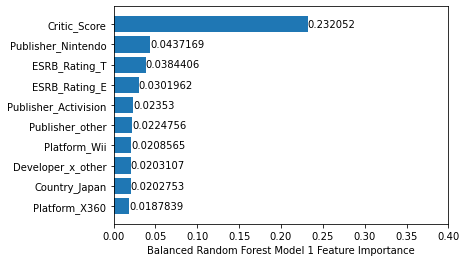

In [137]:
sorted_idx = brf_model_1.feature_importances_.argsort()[-10:]
x = X.columns[sorted_idx]
y = brf_model_1.feature_importances_[sorted_idx]

fig, ax = plt.subplots()
bars = ax.barh(x, y)
ax.bar_label(bars)
plt.xlabel("Balanced Random Forest Model 1 Feature Importance")
plt.xlim(0.0,0.4)

## Easy Ensemble AdaBoost Classifier Model

In [138]:
# Train the EasyEnsembleClassifier
from imblearn.ensemble import EasyEnsembleClassifier 

eec_model = EasyEnsembleClassifier(n_estimators=128, random_state=78)

eec_model_1 = eec_model.fit(X_train, y_train)

In [139]:
# Calculated the balanced accuracy score
y_pred_eec = eec_model_1.predict(X_test)

ecc_acc_score = balanced_accuracy_score(y_test, y_pred_eec)

In [140]:
# Create a DataFrame from the confusion matrix.
cm_eec = confusion_matrix(y_test, y_pred_eec)

cm_eec_df = pd.DataFrame(
    cm_eec, index=["Actual high", "Actual low", "Actual medium"], columns=["Predicted high", "Predicted low", "Predicted medium"])

In [141]:
# Print the imbalanced classification report
print('Model: EasyEnsembleClassifier 1')
print("---------------------")
print("Confusion Matrix")
display(cm_eec_df)
print("---------------------")
print(f"Accuracy Score : {ecc_acc_score}")
print("---------------------")
print("Classification Report")
print(classification_report_imbalanced(y_test, y_pred_eec))

Model: EasyEnsembleClassifier 1
---------------------
Confusion Matrix


,Predicted high,Predicted low,Predicted medium
Actual high,11,0,4
Actual low,25,408,162
Actual medium,44,67,174


---------------------
Accuracy Score : 0.6765246449456975
---------------------
Classification Report
                   pre       rec       spe        f1       geo       iba       sup

       high       0.14      0.73      0.92      0.23      0.82      0.66        15
        low       0.86      0.69      0.78      0.76      0.73      0.53       595
     medium       0.51      0.61      0.73      0.56      0.67      0.44       285

avg / total       0.74      0.66      0.76      0.69      0.71      0.50       895



# Dataframe 2: No 'Critic_Score' column
row count after dropping NaNs = 9383

In [143]:
# Drop 'Critic_Score' column 
no_critic_df = games_df.drop(['Critic_Score','Total_Sales'], axis=1).dropna()
print(no_critic_df.shape)
no_critic_df.head()

(9383, 7)


,Genre,ESRB_Rating,Platform,Publisher,Developer_x,Country,Total_Sales_Class
0,Sports,E,Wii,Nintendo,Nintendo EAD,Japan,high
2,Racing,E,Wii,Nintendo,Nintendo EAD,Japan,high
4,Sports,E,Wii,Nintendo,Nintendo EAD,Japan,high
5,Role-Playing,E,GB,Nintendo,Game Freak,Japan,high
6,Platform,E,DS,Nintendo,Nintendo EAD,Japan,high


In [144]:
# Check unique values
no_critic_df.nunique()

Genre                  19
ESRB_Rating             6
Platform               29
Publisher             100
Developer_x          1387
Country                17
Total_Sales_Class       3
dtype: int64

In [145]:
# Keep top 14 of Genre
top = no_critic_df.Genre.value_counts().index[0:14]
no_critic_df.Genre = np.where(no_critic_df.Genre.isin(top), no_critic_df.Genre,'other')

In [146]:
# Keep top 18 of Platform
top = no_critic_df.Platform.value_counts().index[0:18]
no_critic_df.Platform = np.where(no_critic_df.Platform.isin(top), no_critic_df.Platform,'other')

In [147]:
# Keep top 15 of Publisher
top = no_critic_df.Publisher.value_counts().index[0:15]
no_critic_df.Publisher = np.where(no_critic_df.Publisher.isin(top), no_critic_df.Publisher, 'other')

In [148]:
# Keep top 15 of Developer_x
top = no_critic_df.Developer_x.value_counts().index[0:15]
no_critic_df.Developer_x = np.where(no_critic_df.Developer_x.isin(top), no_critic_df.Developer_x,'other')

In [149]:
# Assign features
X2 = no_critic_df.drop('Total_Sales_Class', axis = 1)
X2

,Genre,ESRB_Rating,Platform,Publisher,Developer_x,Country
0,Sports,E,Wii,Nintendo,Nintendo EAD,Japan
2,Racing,E,Wii,Nintendo,Nintendo EAD,Japan
4,Sports,E,Wii,Nintendo,Nintendo EAD,Japan
5,Role-Playing,E,other,Nintendo,other,Japan
6,Platform,E,DS,Nintendo,Nintendo EAD,Japan
...,...,...,...,...,...,...
19823,Adventure,E10,PC,other,other,United States
19838,Strategy,T,PC,Sega,other,United States
19850,Simulation,M,XOne,other,other,AustriaSweden
19856,Platform,E,3DS,Nintendo,other,Japan


In [150]:
# Encoding object dtype columns
X_cat2 = X2.select_dtypes(include='object')
X_cat2 = list(X_cat2.columns)
X_cat2

['Genre', 'ESRB_Rating', 'Platform', 'Publisher', 'Developer_x', 'Country']

In [151]:
from sklearn.preprocessing import OneHotEncoder

# creating instance of one-hot-encoder
enc = OneHotEncoder(sparse=False)
# Fit and transform the OneHotEncoder using the categorical variable list
encode_df2 = pd.DataFrame(enc.fit_transform(X2[X_cat2]))

# Add the encoded variable names to the dataframe
encode_df2.columns = enc.get_feature_names(X_cat2)

encode_df2

/opt/anaconda3/envs/mlenv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,Genre_Action,Genre_Action-Adventure,Genre_Adventure,Genre_Fighting,Genre_Misc,Genre_Music,Genre_Platform,Genre_Puzzle,Genre_Racing,Genre_Role-Playing,...,Country_Italy,Country_Japan,Country_Netherlands,Country_Norway,Country_Poland,Country_Russia,Country_South Korea,Country_Spain,Country_United Kingdom,Country_United States
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9378,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
9379,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
9380,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9381,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [152]:
# Reset X dataframe index to merge with encode_df
X2.reset_index(drop=True, inplace=True)
X2

,Genre,ESRB_Rating,Platform,Publisher,Developer_x,Country
0,Sports,E,Wii,Nintendo,Nintendo EAD,Japan
1,Racing,E,Wii,Nintendo,Nintendo EAD,Japan
2,Sports,E,Wii,Nintendo,Nintendo EAD,Japan
3,Role-Playing,E,other,Nintendo,other,Japan
4,Platform,E,DS,Nintendo,Nintendo EAD,Japan
...,...,...,...,...,...,...
9378,Adventure,E10,PC,other,other,United States
9379,Strategy,T,PC,Sega,other,United States
9380,Simulation,M,XOne,other,other,AustriaSweden
9381,Platform,E,3DS,Nintendo,other,Japan


In [153]:
# Merge one-hot encoded features and drop the originals
X2 = X2.merge(encode_df2, left_index=True, right_index=True)
X2 = X2.drop(X_cat2, 1)
X2

/var/folders/gd/1878fbxd5zs899fs6znx1h_40000gn/T/ipykernel_12635/2672103516.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  X2 = X2.drop(X_cat2, 1)


,Genre_Action,Genre_Action-Adventure,Genre_Adventure,Genre_Fighting,Genre_Misc,Genre_Music,Genre_Platform,Genre_Puzzle,Genre_Racing,Genre_Role-Playing,...,Country_Italy,Country_Japan,Country_Netherlands,Country_Norway,Country_Poland,Country_Russia,Country_South Korea,Country_Spain,Country_United Kingdom,Country_United States
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9378,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
9379,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
9380,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9381,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Train and fit the model with input data from dataframe 2

In [154]:
# Assign the target
y2 = no_critic_df['Total_Sales_Class']
y2.value_counts()

low       7591
medium    1717
high        75
Name: Total_Sales_Class, dtype: int64

In [155]:
print(X2.shape)
print(y2.shape)

(9383, 89)
(9383,)


In [156]:
# Split data to training and testing set
from sklearn.model_selection import train_test_split
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, random_state=1)

# Check the balance of the target variables.
print(f"y2_train: {Counter(y2_train)}")
print(f"y2_test: {Counter(y2_test)}")

y2_train: Counter({'low': 5677, 'medium': 1303, 'high': 57})
y2_test: Counter({'low': 1914, 'medium': 414, 'high': 18})


In [157]:
# Creating a StandardScaler instance.
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
# Fitting the Standard Scaler with the training data.
X2_scaler = scaler.fit(X2_train)

# Scaling the data.
X2_train_scaled = X2_scaler.transform(X2_train)
X2_test_scaled = X2_scaler.transform(X2_test)

In [158]:
# Fitting the random forest model
rf_model_2 = rf_model.fit(X2_train_scaled, y2_train)

In [159]:
# Making predictions using the testing data.
y2_pred_rf = rf_model_2.predict(X2_test_scaled)

In [160]:
acc_score_2 = accuracy_score(y2_test, y2_pred_rf)

In [161]:
# Create a DataFrame from the confusion matrix.
cm2 = confusion_matrix(y2_test, y2_pred_rf)
cm2_df = pd.DataFrame(
    cm2, index=["Actual high", "Actual low", "Actual medium"], columns=["Predicted high", "Predicted low", "Predicted medium"])

In [162]:
print('Model: Random Forest Classifier 2 (no critic score column)')
print("---------------------")
print("Confusion Matrix")
display(cm2_df)
print("---------------------")
print(f"Accuracy Score : {acc_score_2}")
print("---------------------")
print("Classification Report")
print(classification_report(y2_test, y2_pred_rf))

Model: Random Forest Classifier 2 (no critic score column)
---------------------
Confusion Matrix


,Predicted high,Predicted low,Predicted medium
Actual high,1,7,10
Actual low,0,1783,131
Actual medium,5,262,147


---------------------
Accuracy Score : 0.8231031543052003
---------------------
Classification Report
              precision    recall  f1-score   support

        high       0.17      0.06      0.08        18
         low       0.87      0.93      0.90      1914
      medium       0.51      0.36      0.42       414

    accuracy                           0.82      2346
   macro avg       0.52      0.45      0.47      2346
weighted avg       0.80      0.82      0.81      2346



In [163]:
# Calculate feature importance in the Random Forest model 2.
print("Feature Importance: rf model 2: no 'Critic_Score' column")
sorted(zip(rf_model_2.feature_importances_, X2.columns), reverse=True)

Feature Importance: rf model 2: no 'Critic_Score' column


[(0.06028215275961685, 'Publisher_Nintendo'),
 (0.029586284504111063, 'Platform_PS2'),
 (0.0279180232808411, 'Publisher_other'),
 (0.027269329542860838, 'Genre_Action'),
 (0.02634281428159016, 'Platform_PS3'),
 (0.02627690304096984, 'ESRB_Rating_T'),
 (0.02619146535353908, 'ESRB_Rating_E'),
 (0.024722353383067604, 'Platform_X360'),
 (0.024321790271181597, 'Platform_Wii'),
 (0.023788332731030863, 'Genre_Racing'),
 (0.02332459133091719, 'Genre_Sports'),
 (0.022975581928203228, 'Genre_Shooter'),
 (0.02249921408356072, 'Genre_Role-Playing'),
 (0.022072906225307276, 'ESRB_Rating_M'),
 (0.022049742449468456, 'Developer_x_other'),
 (0.021886991668363446, 'Platform_PS4'),
 (0.021747081616869845, 'Platform_PS'),
 (0.02091890620866227, 'ESRB_Rating_E10'),
 (0.020771177192715352, 'Platform_PC'),
 (0.02073762491219339, 'Genre_Misc'),
 (0.020565516149373506, 'Genre_Platform'),
 (0.01972516860538183, 'Platform_XOne'),
 (0.019260154653976205, 'Publisher_Electronic Arts'),
 (0.01895201713592005, 'Genr

(0.0, 0.4)

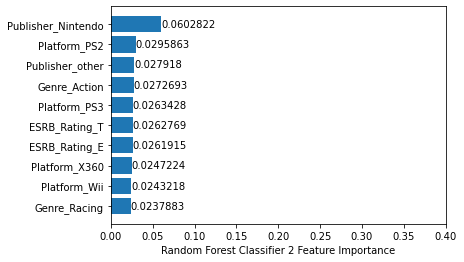

In [164]:
sorted_idx = rf_model_2.feature_importances_.argsort()[-10:]
x = X2.columns[sorted_idx]
y = rf_model_2.feature_importances_[sorted_idx]

fig, ax = plt.subplots()
bars = ax.barh(x, y)
ax.bar_label(bars)
plt.xlabel("Random Forest Classifier 2 Feature Importance")
plt.xlim(0.0,0.4)

In [165]:
# Train the balanced random forest model
brf_model_2 = brf_model.fit(X2_train, y2_train)

In [166]:
# Calculated the balanced accuracy score
y2_pred_brf = brf_model_2.predict(X2_test)

brf_acc_score_2 = balanced_accuracy_score(y2_test, y2_pred_brf)

In [167]:
# Create a DataFrame from the confusion matrix.
cm2_brf = confusion_matrix(y2_test, y2_pred_brf)

cm2_brf_df = pd.DataFrame(
    cm2_brf, index=["Actual high", "Actual low", "Actual medium"], columns=["Predicted high", "Predicted low", "Predicted medium"])

In [168]:
# Print the imbalanced classification report
print('Model: Balanced Random Forest Classifier 2 (no critic score)')
print("---------------------")
print("Confusion Matrix")
display(cm2_brf_df)
print("---------------------")
print(f"Accuracy Score : {brf_acc_score_2}")
print("---------------------")
print("Classification Report")
print(classification_report_imbalanced(y2_test, y2_pred_brf))

Model: Balanced Random Forest Classifier 2 (no critic score)
---------------------
Confusion Matrix


,Predicted high,Predicted low,Predicted medium
Actual high,15,2,1
Actual low,128,1275,511
Actual medium,103,118,193


---------------------
Accuracy Score : 0.6552203696131732
---------------------
Classification Report
                   pre       rec       spe        f1       geo       iba       sup

       high       0.06      0.83      0.90      0.11      0.87      0.75        18
        low       0.91      0.67      0.72      0.77      0.69      0.48      1914
     medium       0.27      0.47      0.73      0.34      0.59      0.33       414

avg / total       0.79      0.63      0.73      0.69      0.68      0.45      2346



In [169]:
# Calculate feature importance
print("Feature Importance: brf model 2")
sorted(zip(brf_model_2.feature_importances_, X2.columns), reverse=True)

Feature Importance: brf model 2


[(0.07558938386810468, 'Publisher_Nintendo'),
 (0.04058137766734985, 'ESRB_Rating_M'),
 (0.037968623584663914, 'ESRB_Rating_T'),
 (0.034458945688016954, 'Publisher_other'),
 (0.02891267393215277, 'Country_Japan'),
 (0.028358331237628015, 'ESRB_Rating_E'),
 (0.028243494122072933, 'Publisher_Activision'),
 (0.027316011328332016, 'Developer_x_other'),
 (0.0264655998781538, 'Genre_Action'),
 (0.025828605469116764, 'Genre_Racing'),
 (0.025394770856072574, 'Platform_PS3'),
 (0.025314349842165535, 'Country_United States'),
 (0.024842354213951923, 'Genre_Role-Playing'),
 (0.02399342144463518, 'Developer_x_Nintendo EAD'),
 (0.023774230459483778, 'Genre_Shooter'),
 (0.021720083936868726, 'Platform_PS2'),
 (0.021546002375517, 'Publisher_Electronic Arts'),
 (0.02135027934948967, 'Publisher_Sony Computer Entertainment'),
 (0.020094672081764128, 'Genre_Sports'),
 (0.019742103300696732, 'ESRB_Rating_E10'),
 (0.019216296939274655, 'Platform_X360'),
 (0.019163615388504522, 'Genre_Misc'),
 (0.0181303059

(0.0, 0.4)

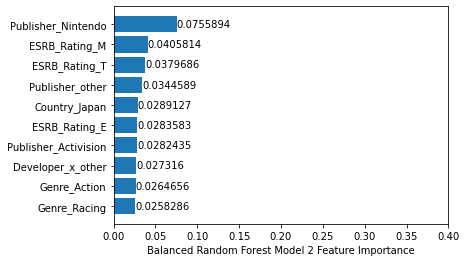

In [170]:
sorted_idx = brf_model_2.feature_importances_.argsort()[-10:]
x = X2.columns[sorted_idx]
y = brf_model_2.feature_importances_[sorted_idx]

fig, ax = plt.subplots()
bars = ax.barh(x, y)
ax.bar_label(bars)
plt.xlabel("Balanced Random Forest Model 2 Feature Importance")
plt.xlim(0.0,0.4)

In [171]:
# Train the EasyEnsembleClassifier model
eec_model_2 = eec_model.fit(X2_train, y2_train)

In [172]:
# Calculated the balanced accuracy score
y2_pred_eec = eec_model_2.predict(X2_test)

ecc_acc_score_2 = balanced_accuracy_score(y2_test, y2_pred_eec)

In [173]:
# Create a DataFrame from the confusion matrix.
cm2_eec = confusion_matrix(y2_test, y2_pred_eec)

cm2_eec_df = pd.DataFrame(
    cm2_eec, index=["Actual high", "Actual low", "Actual medium"], columns=["Predicted high", "Predicted low", "Predicted medium"])

In [174]:
# Print the imbalanced classification report
print('Model: EasyEnsembleClassifier 2 (no critic score)')
print("---------------------")
print("Confusion Matrix")
display(cm2_eec_df)
print("---------------------")
print(f"Accuracy Score : {ecc_acc_score_2}")
print("---------------------")
print("Classification Report")
print(classification_report_imbalanced(y2_test, y2_pred_eec))

Model: EasyEnsembleClassifier 2 (no critic score)
---------------------
Confusion Matrix


,Predicted high,Predicted low,Predicted medium
Actual high,15,2,1
Actual low,178,1148,588
Actual medium,93,116,205


---------------------
Accuracy Score : 0.6427644763476847
---------------------
Classification Report
                   pre       rec       spe        f1       geo       iba       sup

       high       0.05      0.83      0.88      0.10      0.86      0.73        18
        low       0.91      0.60      0.73      0.72      0.66      0.43      1914
     medium       0.26      0.50      0.70      0.34      0.59      0.34       414

avg / total       0.79      0.58      0.72      0.65      0.65      0.42      2346



# Dataframe 3: No 'Critic_Score' and 'Country' columns
row count after dropping NaNs = 13922

In [175]:
# Drop 'Country' column 
no_country_critic_df = games_df.drop(['Country', 'Critic_Score', 'Total_Sales'], axis=1).dropna()
print(no_country_critic_df.shape)
no_country_critic_df.head()

(13923, 6)


,Genre,ESRB_Rating,Platform,Publisher,Developer_x,Total_Sales_Class
0,Sports,E,Wii,Nintendo,Nintendo EAD,high
2,Racing,E,Wii,Nintendo,Nintendo EAD,high
4,Sports,E,Wii,Nintendo,Nintendo EAD,high
5,Role-Playing,E,GB,Nintendo,Game Freak,high
6,Platform,E,DS,Nintendo,Nintendo EAD,high


In [176]:
# Check unique values
no_country_critic_df.nunique()

Genre                  20
ESRB_Rating             6
Platform               31
Publisher             432
Developer_x          2250
Total_Sales_Class       3
dtype: int64

In [177]:
# Keep top 14 of Genre
top = no_country_critic_df.Genre.value_counts().index[0:14]
no_country_critic_df.Genre = np.where(no_country_critic_df.Genre.isin(top), no_country_critic_df.Genre,'other')

In [178]:
# Keep top 18 of Platform
top = no_country_critic_df.Platform.value_counts().index[0:18]
no_country_critic_df.Platform = np.where(no_country_critic_df.Platform.isin(top), no_country_critic_df.Platform,'other')

In [179]:
# Keep top 15 of Publisher
top = no_country_critic_df.Publisher.value_counts().index[0:15]
no_country_critic_df.Publisher = np.where(no_country_critic_df.Publisher.isin(top), no_country_critic_df.Publisher, 'other')

In [180]:
# Keep top 15 of Developer_x
top = no_country_critic_df.Developer_x.value_counts().index[0:15]
no_country_critic_df.Developer_x = np.where(no_country_critic_df.Developer_x.isin(top), no_country_critic_df.Developer_x,'other')

In [181]:
# Assign features
X3 = no_country_critic_df.drop('Total_Sales_Class', axis = 1)
X3

,Genre,ESRB_Rating,Platform,Publisher,Developer_x
0,Sports,E,Wii,Nintendo,Nintendo EAD
2,Racing,E,Wii,Nintendo,Nintendo EAD
4,Sports,E,Wii,Nintendo,Nintendo EAD
5,Role-Playing,E,other,Nintendo,other
6,Platform,E,DS,Nintendo,Nintendo EAD
...,...,...,...,...,...
19850,Simulation,M,XOne,other,other
19854,Adventure,E,DS,Majesco,other
19856,Platform,E,3DS,Nintendo,other
19857,Simulation,T,PC,other,other


In [182]:
# Encoding object dtype columns
X_cat3 = X3.select_dtypes(include='object')
X_cat3 = list(X_cat3.columns)
X_cat3

['Genre', 'ESRB_Rating', 'Platform', 'Publisher', 'Developer_x']

In [183]:
from sklearn.preprocessing import OneHotEncoder

# creating instance of one-hot-encoder
enc = OneHotEncoder(sparse=False)
# Fit and transform the OneHotEncoder using the categorical variable list
encode_df3 = pd.DataFrame(enc.fit_transform(X3[X_cat3]))

# Add the encoded variable names to the dataframe
encode_df3.columns = enc.get_feature_names(X_cat3)

encode_df3

/opt/anaconda3/envs/mlenv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,Genre_Action,Genre_Action-Adventure,Genre_Adventure,Genre_Fighting,Genre_Misc,Genre_Music,Genre_Platform,Genre_Puzzle,Genre_Racing,Genre_Role-Playing,...,Developer_x_Omega Force,Developer_x_Square Enix,Developer_x_THQ,Developer_x_Traveller's Tales,Developer_x_Ubisoft,Developer_x_Ubisoft Montreal,Developer_x_Unknown,Developer_x_Vicarious Visions,Developer_x_Visual Concepts,Developer_x_other
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13918,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
13919,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
13920,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
13921,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [184]:
# Reset X dataframe index to merge with encode_df
X3.reset_index(drop=True, inplace=True)
X3

,Genre,ESRB_Rating,Platform,Publisher,Developer_x
0,Sports,E,Wii,Nintendo,Nintendo EAD
1,Racing,E,Wii,Nintendo,Nintendo EAD
2,Sports,E,Wii,Nintendo,Nintendo EAD
3,Role-Playing,E,other,Nintendo,other
4,Platform,E,DS,Nintendo,Nintendo EAD
...,...,...,...,...,...
13918,Simulation,M,XOne,other,other
13919,Adventure,E,DS,Majesco,other
13920,Platform,E,3DS,Nintendo,other
13921,Simulation,T,PC,other,other


In [185]:
# Merge one-hot encoded features and drop the originals
X3 = X3.merge(encode_df3, left_index=True, right_index=True)
X3 = X3.drop(X_cat3, 1)
X3

/var/folders/gd/1878fbxd5zs899fs6znx1h_40000gn/T/ipykernel_12635/4159634020.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  X3 = X3.drop(X_cat3, 1)


,Genre_Action,Genre_Action-Adventure,Genre_Adventure,Genre_Fighting,Genre_Misc,Genre_Music,Genre_Platform,Genre_Puzzle,Genre_Racing,Genre_Role-Playing,...,Developer_x_Omega Force,Developer_x_Square Enix,Developer_x_THQ,Developer_x_Traveller's Tales,Developer_x_Ubisoft,Developer_x_Ubisoft Montreal,Developer_x_Unknown,Developer_x_Vicarious Visions,Developer_x_Visual Concepts,Developer_x_other
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13918,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
13919,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
13920,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
13921,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


### Train and fit the model with input data from dataframe 3

In [186]:
# Assign the target
y3 = no_country_critic_df['Total_Sales_Class']
y3.value_counts()

low       11818
medium     2024
high         81
Name: Total_Sales_Class, dtype: int64

In [187]:
print(X3.shape)
print(y3.shape)

(13923, 72)
(13923,)


In [188]:
# Split data to training and testing set
from sklearn.model_selection import train_test_split
X3_train, X3_test, y3_train, y3_test = train_test_split(X3, y3, random_state=1)

# Check the balance of the target variables.
print(f"y3_train: {Counter(y3_train)}")
print(f"y3_test: {Counter(y3_test)}")

y3_train: Counter({'low': 8870, 'medium': 1512, 'high': 60})
y3_test: Counter({'low': 2948, 'medium': 512, 'high': 21})


In [189]:
# Creating a StandardScaler instance.
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
# Fitting the Standard Scaler with the training data.
X3_scaler = scaler.fit(X3_train)

# Scaling the data.
X3_train_scaled = X3_scaler.transform(X3_train)
X3_test_scaled = X3_scaler.transform(X3_test)

In [190]:
# Fitting the model
rf_model_3 = rf_model.fit(X3_train_scaled, y3_train)
# Making predictions using the testing data.
y3_pred_rf = rf_model_3.predict(X3_test_scaled)
acc_score_3 = accuracy_score(y3_test, y3_pred_rf)

In [191]:
print('Model: Random Forest Classifier 3')
print("---------------------")
print(f"Accuracy Score : {acc_score_3}")
print("---------------------")
print("Classification Report")
print(classification_report(y3_test, y3_pred_rf))

Model: Random Forest Classifier 3
---------------------
Accuracy Score : 0.8520540074691181
---------------------
Classification Report
              precision    recall  f1-score   support

        high       0.33      0.19      0.24        21
         low       0.89      0.95      0.92      2948
      medium       0.51      0.31      0.38       512

    accuracy                           0.85      3481
   macro avg       0.58      0.48      0.51      3481
weighted avg       0.83      0.85      0.84      3481



In [192]:
# Calculate feature importance
print("Feature Importance: rf model 3")
sorted(zip(rf_model_3.feature_importances_, X3.columns), reverse=True)

Feature Importance: rf model 3


[(0.06439212916071538, 'Publisher_Nintendo'),
 (0.0278789739377146, 'Platform_PS2'),
 (0.027698430403063527, 'ESRB_Rating_T'),
 (0.026908550652129132, 'Publisher_other'),
 (0.026614234063756733, 'Genre_Action'),
 (0.026112154024028448, 'ESRB_Rating_E'),
 (0.02421010011291115, 'ESRB_Rating_E10'),
 (0.024038041977844874, 'ESRB_Rating_M'),
 (0.0237846609709522, 'Platform_Wii'),
 (0.023552054615823426, 'Platform_PS3'),
 (0.02354375054296208, 'Genre_Racing'),
 (0.023426595672462774, 'Genre_Role-Playing'),
 (0.02336933312650466, 'Developer_x_other'),
 (0.02295490774406984, 'Genre_Sports'),
 (0.02281287649966017, 'Platform_PS4'),
 (0.02221122316991156, 'Genre_Platform'),
 (0.02214675704104023, 'Genre_Misc'),
 (0.02211976869644304, 'Genre_Shooter'),
 (0.022070615939658162, 'Platform_PS'),
 (0.022021967693641266, 'Platform_PC'),
 (0.021412284499923776, 'Publisher_Electronic Arts'),
 (0.021395324837193513, 'Platform_X360'),
 (0.021180075875615396, 'Genre_Adventure'),
 (0.017280891522155038, 'Pub

(0.0, 0.45)

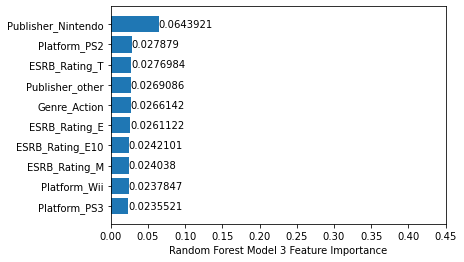

In [193]:
sorted_idx = rf_model_3.feature_importances_.argsort()[-10:]
x = X3.columns[sorted_idx]
y = rf_model_3.feature_importances_[sorted_idx]

fig, ax = plt.subplots()
bars = ax.barh(x, y)
ax.bar_label(bars)
plt.xlabel("Random Forest Model 3 Feature Importance")
plt.xlim(0.0,0.45)

In [194]:
# Fitting the BalancedRandomForestClassifier model
brf_model_3 = brf_model.fit(X3_train, y3_train)
y3_pred_brf = brf_model_3.predict(X3_test)

brf_acc_score_3 = balanced_accuracy_score(y3_test, y3_pred_brf)

In [195]:
# Print the imbalanced classification report
print('Model: Balanced Random Forest Classifier 3')
print("---------------------")
print(f"Accuracy Score : {brf_acc_score_3}")
print("---------------------")
print("Classification Report")
print(classification_report_imbalanced(y3_test, y3_pred_brf))

Model: Balanced Random Forest Classifier 3
---------------------
Accuracy Score : 0.6501291062275204
---------------------
Classification Report
                   pre       rec       spe        f1       geo       iba       sup

       high       0.04      0.81      0.89      0.08      0.85      0.71        21
        low       0.93      0.70      0.70      0.80      0.70      0.49      2948
     medium       0.27      0.44      0.79      0.33      0.59      0.34       512

avg / total       0.83      0.66      0.71      0.72      0.68      0.47      3481



In [196]:
# Calculate feature importance
print("Feature Importance: brf model 3")
sorted(zip(brf_model_3.feature_importances_, X3.columns), reverse=True)

Feature Importance: brf model 3


[(0.08301797282176177, 'Publisher_Nintendo'),
 (0.04615318849823696, 'Publisher_other'),
 (0.03789866697562412, 'ESRB_Rating_M'),
 (0.03527535527818082, 'Genre_Action'),
 (0.03331006113051422, 'ESRB_Rating_T'),
 (0.030200495580010634, 'Platform_X360'),
 (0.026558667706537354, 'Genre_Platform'),
 (0.02634812514312332, 'Genre_Shooter'),
 (0.02627393653692552, 'ESRB_Rating_E'),
 (0.026207136300268503, 'Publisher_Activision'),
 (0.0258360739072335, 'Genre_Role-Playing'),
 (0.024634880526874944, 'Developer_x_other'),
 (0.02454148272471339, 'Platform_PS4'),
 (0.02348035952041791, 'Developer_x_Nintendo EAD'),
 (0.023449723181670774, 'Platform_Wii'),
 (0.02283381154430561, 'Platform_PS3'),
 (0.02282022063024473, 'Platform_PC'),
 (0.02253383531085737, 'Platform_PS2'),
 (0.019996514005065722, 'Genre_Sports'),
 (0.01916094779882566, 'ESRB_Rating_E10'),
 (0.01847595513890943, 'Genre_Misc'),
 (0.018440526568436127, 'Genre_Racing'),
 (0.017882734795555053, 'Genre_Adventure'),
 (0.017606369534578337,

(0.0, 0.45)

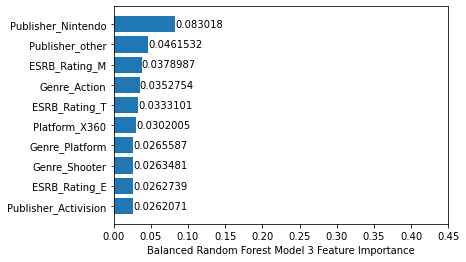

In [197]:
sorted_idx = brf_model_3.feature_importances_.argsort()[-10:]
x = X3.columns[sorted_idx]
y = brf_model_3.feature_importances_[sorted_idx]

fig, ax = plt.subplots()
bars = ax.barh(x, y)
ax.bar_label(bars)
plt.xlabel("Balanced Random Forest Model 3 Feature Importance")
plt.xlim(0.0,0.45)

In [198]:
# Fitting the EasyEnsembleClassifier model
eec_model_3 = eec_model.fit(X3_train, y3_train)
y3_pred_eec = eec_model_3.predict(X3_test)

ecc_acc_score_3 = balanced_accuracy_score(y3_test, y3_pred_eec)

In [199]:
# Print the imbalanced classification report
print('Model: EasyEnsembleClassifier 3')
print("---------------------")
print(f"Accuracy Score : {ecc_acc_score_3}")
print("---------------------")
print("Classification Report")
print(classification_report_imbalanced(y3_test, y3_pred_eec))

Model: EasyEnsembleClassifier 3
---------------------
Accuracy Score : 0.5470210921178739
---------------------
Classification Report
                   pre       rec       spe        f1       geo       iba       sup

       high       0.02      0.52      0.86      0.04      0.67      0.44        21
        low       0.92      0.64      0.70      0.75      0.67      0.45      2948
     medium       0.26      0.48      0.76      0.33      0.60      0.35       512

avg / total       0.82      0.61      0.71      0.69      0.66      0.43      3481

